### 2024.9.6 22:40
现在是写完了联合标签训练的测试，但有问题：第一个是标签不均衡的问题，共有的那几个类几率会增高，显然不对劲。
另一个是MLP的drop_out上，train和val的时候输出的logits差别很大。train的时候是正常的，但val时候所有样本logits同质化。原因好像是val的时候会自动关闭模型中的dropout层（删掉dropout会导致train和val全变成左边的样子......
现在是准备跑一下单个数据集（Faced 9 class）上的Baseline，看看logits同质化的问题是否只是初期现象，会不会随着训练好转。

#### val时batch内logits同质化，以及train时的正常logits，以及对应标签（Faced 56*9）
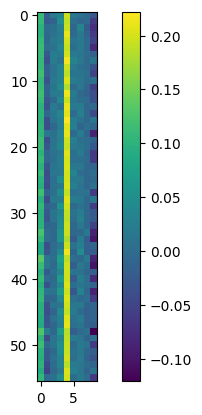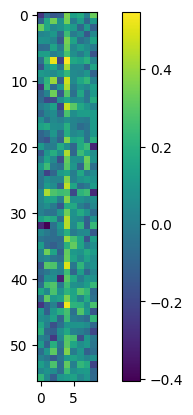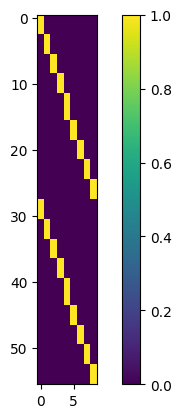
#### 计算的一个batch的de特征实例，看起来还算正常？
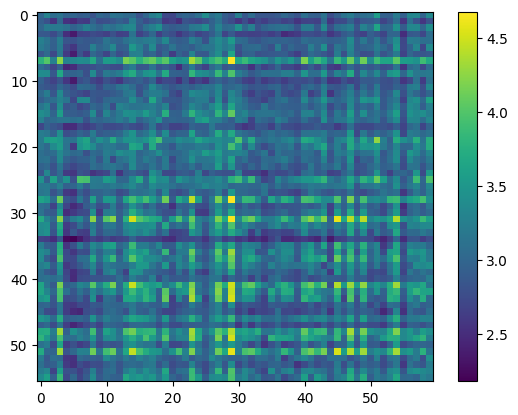
#### 标签不均衡logits
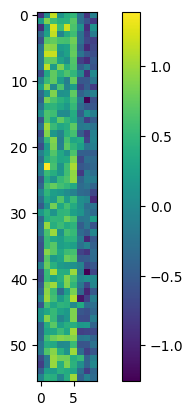

#### 涉事MLP代码

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim, dropout=0.2, bn='no'):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # if (bn == 'bn1') or (bn == 'bn2'):
        self.bn1 = nn.BatchNorm1d(hidden_dim, affine=False)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        # if bn == 'bn2':
        self.bn2 = nn.BatchNorm1d(hidden_dim//2, affine=False)
        self.fc3 = nn.Linear(hidden_dim//2, out_dim)
        self.bn = bn
        self.drop = nn.Dropout(p=dropout)
        # self.flag = False
    def forward(self, input):

        out = F.relu(self.fc1(input))

        if (self.bn == 'bn1') or (self.bn == 'bn2'):
            out = self.bn1(out)
        out = self.drop(out)
        out = F.relu(self.fc2(out))

        if self.bn == 'bn2':
            out = self.bn2(out)
        out = self.drop(out)
        out = self.fc3(out)

        return out

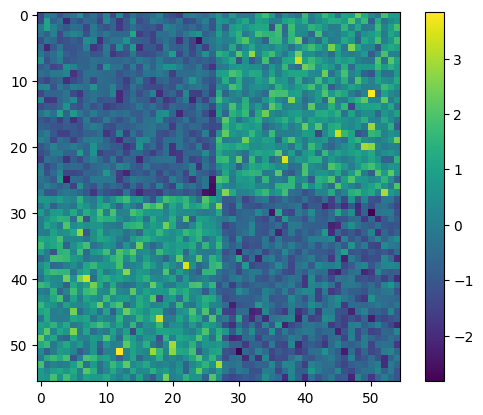

### 2024.9.11 13:36
现在能正常过拟合了，但是非常慢。要几个小时。

该版本代码：https://github.com/soul-M-42/Covariance_EEG_Emotion/commit/cabc8cad0eb390cf5e1ee75b9e1ea876b3e31a3c

该版本loss和acc：\\10.16.32.74\dataset0\qingzhu\workspace\log_worth\24_9_11_clisa_Proj_only

loss和acc预览（橙色为fold0,蓝色为fold1）：
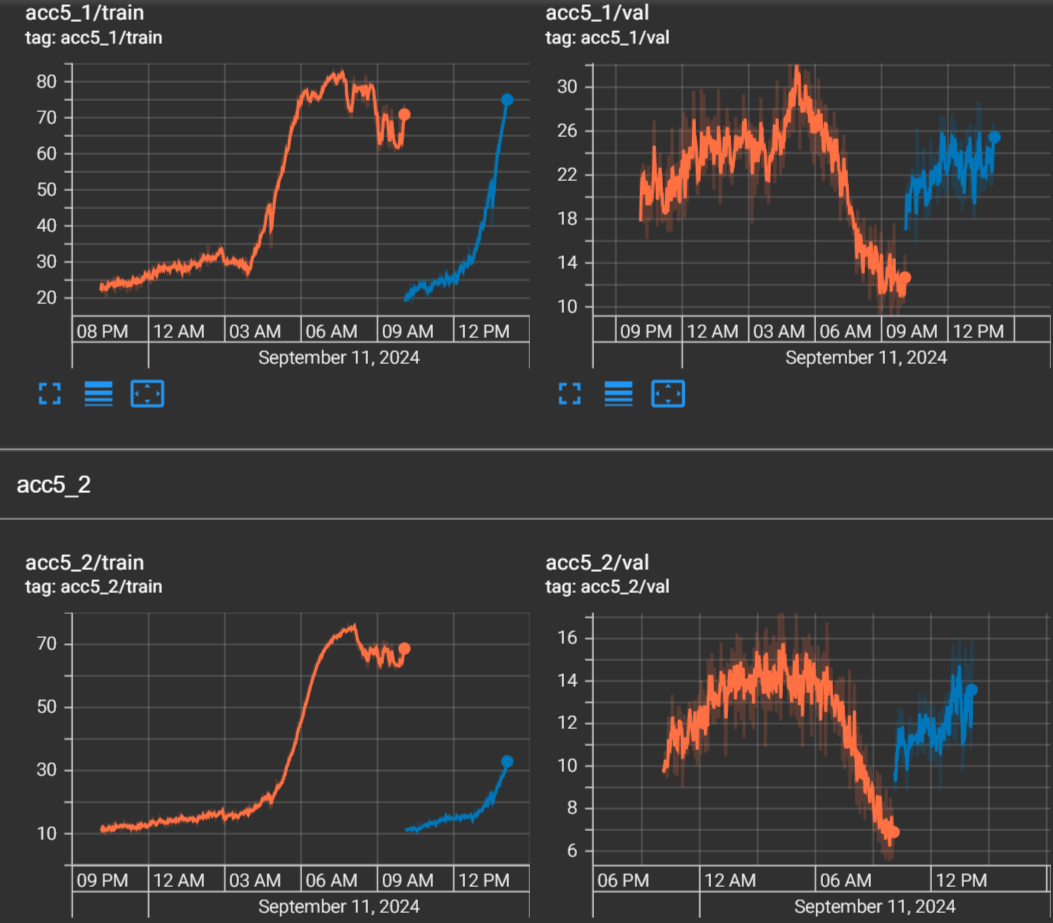
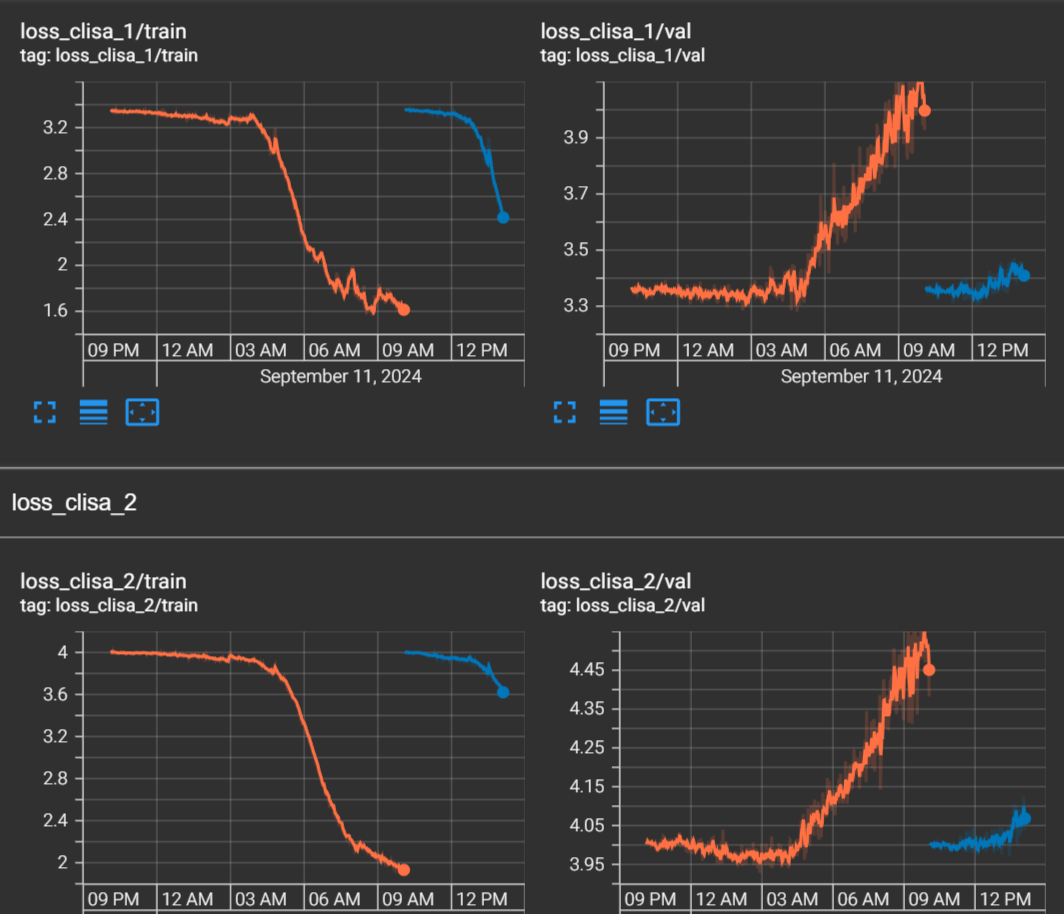

可能导致该变化的调整：
1. 在以下位置加入strafied_layernorm：[EEG数据输入，Clisa_Proj(和新科版本Clisa_Proj保持一致)]
2. 修改了stratified_layernorm的细节，改回了正确版本的老norm
3. 向loss_clisa_fea中加入了temperature=0.3项

为何过拟合得这么慢？有以下猜测：
1. 是在用两个数据集训练一套参数，数据本身就比较diverse
2. wd=0
3. lr start from 1e-2
4. 降低MLLA输出维度
5. 单个数据集验证
6. 加入对齐loss


### 2024.9.12
#### 修改sampler，在全部数据上，但限制样本对数量，随机！

重要更新1：之前收敛速度瓶颈在Channel_Alignment上。之前相当于把[batch_size, n_channel, n_dim]的数据先reshape成[batch_size, -1]再用一个[n_channel*n_dim]的参数量巨大的全连接进行对齐。现在改成了只在n_channel维度上进行线性组合。

重要更新2：clisa_proj的卷积，同样不merge两个维度，而是定义在一个方向上kernel_size为1，另一个方向上为正常size。

总之：避免数据某一维度贼大

### 2024.9.13
1. 加分类loss
2. 绘制top_1, top_5 acc √
2. 增加Channel_align层数 √
3. 单个数据集上实验 √

### 重要：DataLoader需要Debug
 试了Clisa原版的Single Datasampler，感觉Dual Dataloader有问题，慢得很多。相同模型下，用原版Dataloader能跑到5.43it/s，但用Dual只有0.87it/s.
 而且训练效果也差别很大。

 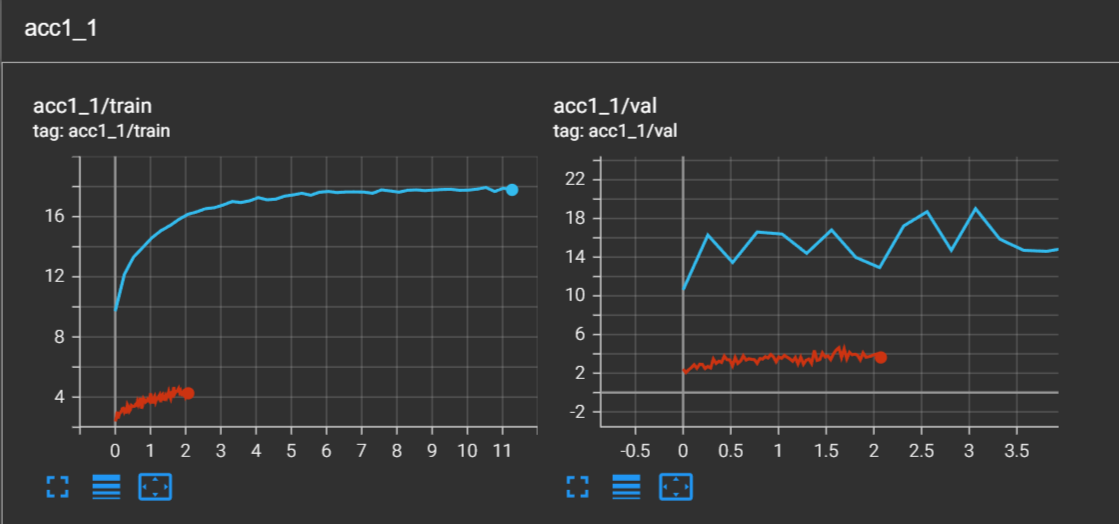
 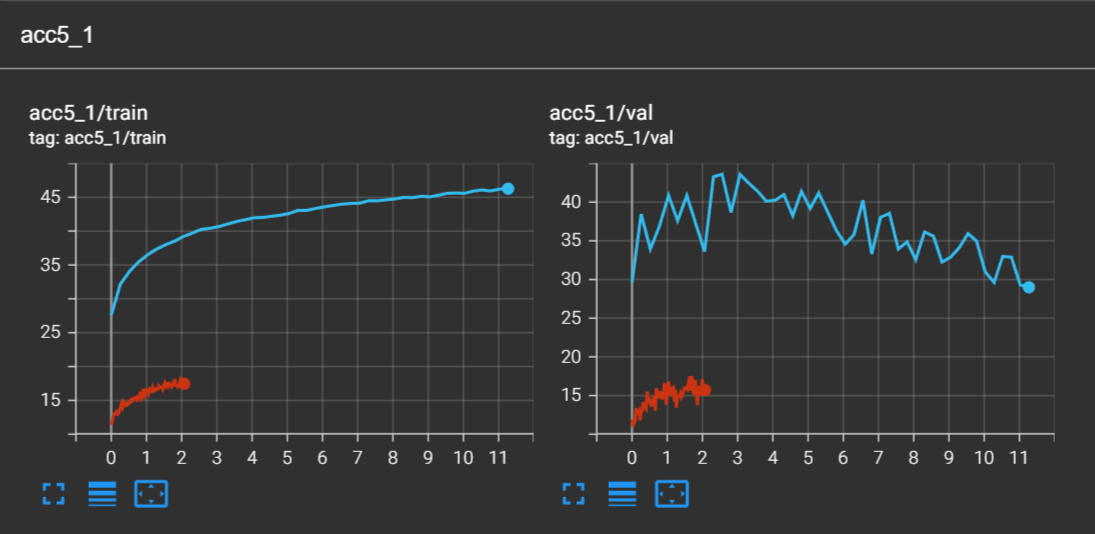
 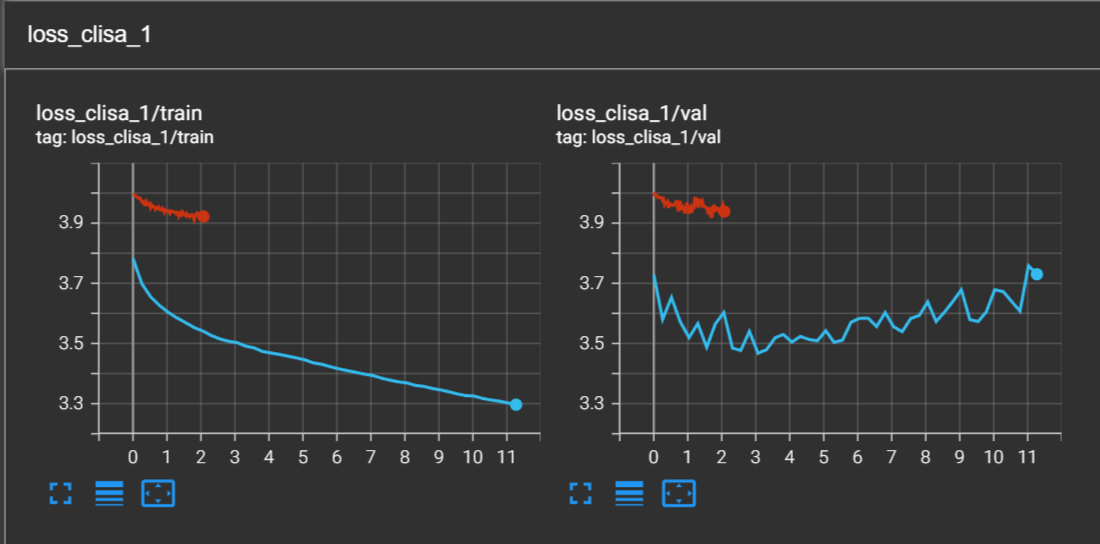

### 2024.9.14

找到了之前一直训不起来的问题所在。
对于来自同一数据集的两个个体，get_sample(subsession)只能运行一次，采样特定的视频片段开始时间点，而后赋给两个被试个体。之前的写法是，对于两个个体的subsession，分别进行了两次get_sample，导致两个个体的每个视频片段的起始时间点都不一样。这样子虽然也能训练，但极其困难。因为是真·除了视频其他什么共性都没有。

画图说明：
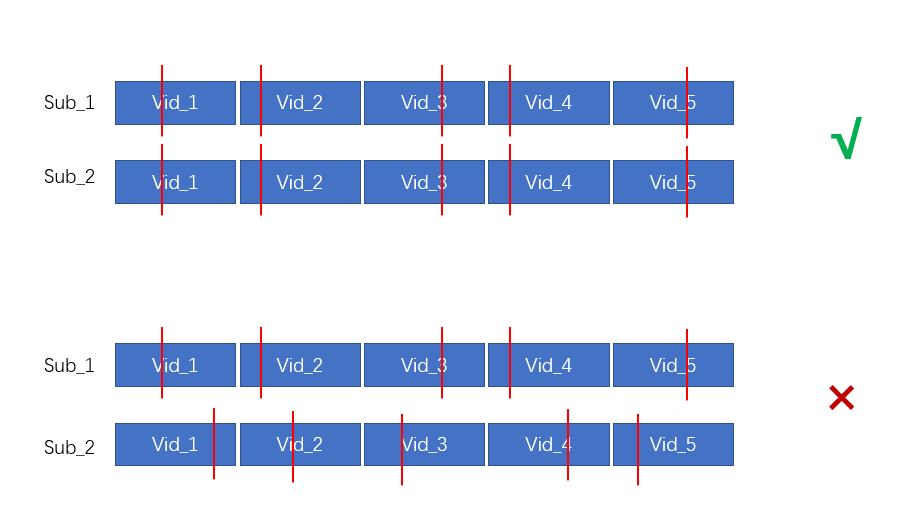


### 2024.9.14 todo

1. MLP先不共享标签了，每一个数据集训练一个小的分类MLP
2. 为了保证MLP参数小，从两个地方入手：一个是缩小MLLA的out_dim，比如到3；另一个是T'维度可以到1
3.可以先在单个数据集上训一下MLP看看效果

### 2024.9.18 todo
1. 联合3个数据集（两个训练一个测试）√，并加入CDA_loss ×
2. 让MLP_loss只作用于MLP，不影响MLLA_clisa训练 √

### 2024.9.20 todo
1. 在MLP前加入LDS平滑，再分类
2. 加入CDA损失，比较效果
3. 对data_3反过来，用一小部分人做微调训练，大部分人做测试

### 2024.9.23 todo

今日发现MLLA encoder存在问题。把MLLA channelwise encoder、alignment module和clisa_projector换成老clisa代码使用的cnn_simple_new后训练效果飞升。

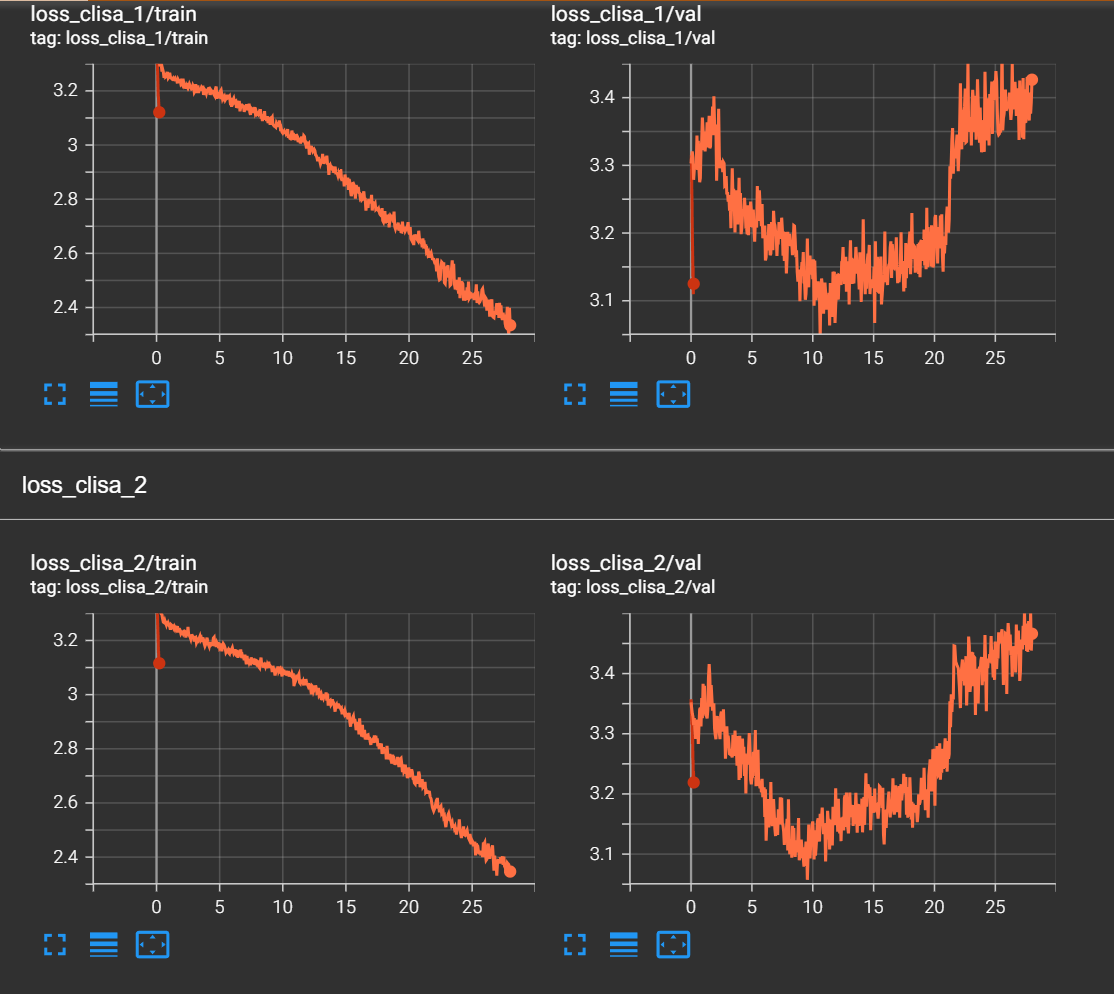

### 2024.9.24
I guess theres still something wrong with the dataloader. fuck.

### 2024.9.26

1. fixed extract_fea_multi, now final classification acc1 60/30(SEED)
2. found crucial parameter: for MLLA encoder, smaller stride (longer sequence T') works better

### 2024.10.9

### 2024.10.10
todo:
1. 对于MLLA输出维度太小则训不好CLISA，太大则算不了协方差的问题：取用较大的输出维度，优先保障CLISA训练，之后算n_dim个协方差，再做平均

2. 再加入一个数据集：使用2个SEED+1个Faced训练，在第三个SEED上验证

3. 验证时，将协方差对齐到训练所用协方差上。具体方法：在ckpt中增加保存每个训练集的协方差矩阵特征（3个N*N


### 2024.10.22
未经finetune的base.ckpt的feature分布，训1推3

### 2024.10.25 跨个体迁移结果

### small group finetune 4=1:3

pre model me: 46.33±3.21

finetuned: 47.88±3.20

DE：44.3±4.04

### small group finetune 8=1:7

pre model me: 42.35±2.14

finetuned: 38.92±4.35

DE：40.53±3.81



数据集划分方式：

1. 少数个体作为微调样本，多数个体作为测试

2. 对于每个个体，少量/单个视频作为微调样本，剩余视频作为测试

3. 对于目标数据集所有样本，每个个体取少量/单个视频作为微调样本，剩余视频作为测试

### 2024.10.29 被试内迁移(无lds)

2:8

DE: 68.04±8.02

pre model me: 45.30±4.78

finetuned: 

8:2

DE: 79.58±8.65

pre model me: 60.00±7.48

### 2024.10.30 Towards a better base.ckpt

1. 对MLLA模型，更大的hidden_dim（128）会获得更好的效果

梯度消失？ Too deep

最好在clisa训练阶段加入cov_align_loss.尽管train_loss上表现不出来，但实际上是（有可能）防止过拟合的。

加上，和昨晚的结果对比一下。

MLLA模型中缺少空间关系提取。clisa_proj前加个空间卷积试试呢

↑ IT WORKS!!

矩阵形状: (117744, 256)


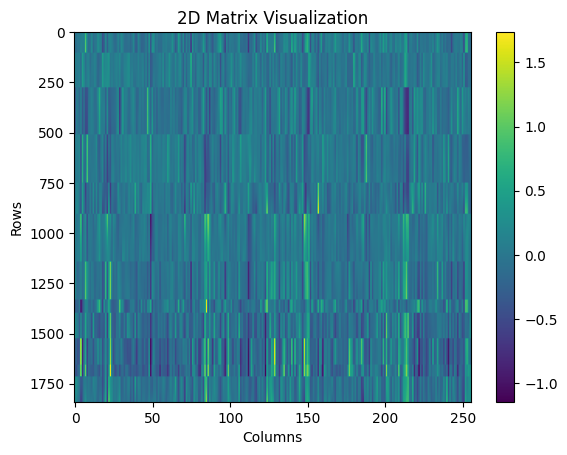

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os

def load_and_visualize_npy(file_path):
    # 加载 .npy 文件
    matrix = np.load(file_path)
    # 打印矩阵的形状
    print(f"矩阵形状: {matrix.shape}")
    matrix = matrix[1*7359//4:2*7359//4, :]
    
    # 判断是否可以进行二维可视化
    if matrix.ndim == 2:
        plt.imshow(matrix, cmap='viridis', aspect='auto')
        plt.colorbar()
        plt.title("2D Matrix Visualization")
        plt.xlabel("Columns")
        plt.ylabel("Rows")
        plt.show()
    else:
        print("此矩阵不是二维的，无法进行二维可视化")

# 示例用法
file_path = "/mnt/dataset0/qingzhu/AutoICA_Processed_EEG/SEED_V/Processed_data_filter_0.50_47.00_AutoICA_Def_Threshold/data_3in1/ext_fea"  # 替换为你的文件路径
file_name = 'CNN_baseline_f1_fea_pretrain_me.npy'

# file_path = "/mnt/dataset0/qingzhu/AutoICA_Processed_EEG/SEED/Processed_data_filter_0.50_47.00_AutoICA_Cus_Threshold/ext_fea"  # 替换为你的文件路径
# file_name = 'MLLA_spatial2_f0_fea_pretrain_me.npy'
file_path = os.path.join(file_path, file_name)
load_and_visualize_npy(file_path)

In [ ]:
2024.11.4

确定过拟合发生在预训练还是finetune
使用更小更浅的MLLA



Now: see if fintune with cov align loss would better emotion classification

2024.11.5

使用vanilla clisa原版CNN模型，都能达到44%左右1迁3准确率，和DE水平相仿
训练30epoch clisa_cnn_baseline模型，看1迁3能到多少，然后逐步替换掉模块，增加通道对齐和MLLA

### 2024.11.6 调1测3

从cnn_att开始迭代


DE：44.03±4.04

cnn_att 直接用SEED的mlp: 50.29±1.68

cnn_att 为SEEDV微调新的mlp: 略低于上面

conv换MLLA 30 直接用SEED的mlp: 49.80±3.65

conv换MLLA 30 为SEEDV微调新的mlp: 45.60±4.97

conv换MLLA 10 直接用SEED的mlp: 50.83±2.85

conv换MLLA 10 为SEEDV微调新的mlp: 44.52±4.40

conv换MLLA 20 直接用SEED的mlp: 51.66±4.38

conv换MLLA 20 为SEEDV微调新的mlp: **

MLLA后接Align 20 直接用SEED的mlp: **56.94±2.90**

MLLA后接Align 20 为SEEDV微调新的mlp: 50.11±4.05


